In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import os

import tqdm
import random
import warnings
import albumentations as A
warnings.filterwarnings('ignore')

In [1]:
! unzip -qq tree_primige.zip

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm

class Video2Class(Dataset):
    def __init__(self, concrete_folder, priming_folder,
                 brick_folder, tree_folder, test=False,
                 test_size=0.2, transform=None):

        super(Video2Class, self).__init__()
        self.flag = True
        self.concrete_file_names = [f for f in os.listdir(concrete_folder) if f.endswith('.mp4')]
        self.priming_file_names = [f for f in os.listdir(priming_folder) if f.endswith('.mp4')]
        self.tree_file_names = [f for f in os.listdir(tree_folder) if f.endswith('.mp4')]
        self.brick_file_names = [f for f in os.listdir(brick_folder) if f.endswith('.mp4')]
        # print(self.concrete_file_names[-1], self.concrete_file_names[-2])

        # self.concrete_file_names = self.concrete_file_names[:10]
        # self.priming_file_names = self.priming_file_names[:10]
        # self.tree_file_names = self.tree_file_names[:10]
        # self.brick_file_names = self.brick_file_names[:10]

        self.data = []
        # print(self.concrete_file_names, self.priming_file_names, self.tree_file_names, self.brick_file_names)
        self.trans  = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.weather_transforms = [A.Compose([A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1)],),
                                   A.Compose([A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)],),
                                   A.Compose([A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1)],),
                                   A.Compose([A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.1, p=1)],),
                                   
                                   ]
    
        self.give_data(concrete_folder, self.concrete_file_names, 0)
        self.give_data(priming_folder, self.priming_file_names, 1)
        self.give_data(tree_folder, self.tree_file_names, 2)
        self.give_data(brick_folder, self.brick_file_names, 3)

        
        
    def give_data(self, folder_name, file_list, class_id):
        random_rotation = transforms.RandomRotation(degrees=(-45, 45))
        brightness_transform = transforms.ColorJitter(brightness=1.8)
        for filename in tqdm(file_list):
            name = os.path.join(folder_name, filename)
            video_file = []

            start_time = 119  # начальное время (2 минуты)
            end_time = 135    # конечное время (3 минуты)

            # Открываем исходное видеофайл
            video = cv2.VideoCapture(name)

            # Вычисляем FPS (кадры в секунду)
            fps = int(video.get(cv2.CAP_PROP_FPS))

            # Вычисляем количество кадров, которые нужно пропустить
            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            # Устанавливаем текущий кадр на начальный
            video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            # Обрабатываем и отображаем кадры в заданном временном промежутке
            for frame_number in range(start_frame, end_frame):
                ret, frame = video.read()
                if not ret:
                    break
                video_file.append(frame)

            # Закрываем видеопоток
            video.release()
            first = int(16 *fps ) - 1
            second = first - (fps * 5)
            third = second - fps * 10


            
            for k in range(4):
                wt_tr = self.weather_transforms[k]
                w1, w2, w3 = wt_tr(image=video_file[third]), wt_tr(image=video_file[second]), wt_tr(image=video_file[first])
                w = torch.from_numpy(np.stack([w1['image'], w2['image'], w3['image']])).permute(0, 3, 1, 2) / 255.
                self.data.append((self.trans(w), class_id))
            
            self.blur_photo(video_file[third], video_file[second], video_file[first], class_id)
            
            
            video_itg = torch.from_numpy(np.stack([video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2) / 255.
            video_rot = random_rotation(video_itg)
            
            
    
            video_light = brightness_transform(video_itg)
            video_light = self.trans(video_light)
            rot_light = brightness_transform(video_rot)
            rot_light = self.trans(rot_light)
            self.data.append((video_light, class_id))
            self.data.append((rot_light, class_id))
            

            video_rot = self.trans(video_rot)
            video_itg = self.trans(video_itg)
            if self.flag:
                print(video_itg.shape)
                self.flag = False
            self.data.append((video_itg, class_id))
            self.data.append((video_rot, class_id))

    def blur_photo(self, img1, img2, img3, class_id):
        blurred_image1 = cv2.GaussianBlur(img1, (21, 21), 0) 
        blurred_image2 = cv2.GaussianBlur(img2, (21, 21), 0) 
        blurred_image3 = cv2.GaussianBlur(img3, (21, 21), 0) 
        
        blurred_itg = torch.from_numpy(np.stack([blurred_image1, blurred_image2, blurred_image3])).permute(0, 3, 1, 2) / 255
        blurred_itg = self.trans(blurred_itg)
        self.data.append((blurred_itg, class_id))

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]


In [142]:
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm

class TestClass(Dataset):
    def __init__(self, concrete_folder, priming_folder,
                 brick_folder, tree_folder, test=False,
                 test_size=0.2, transform=None):

        super(TestClass, self).__init__()
        self.flag = True
        self.concrete_file_names = [f for f in os.listdir(concrete_folder) if f.endswith('.mp4')]
        self.priming_file_names = [f for f in os.listdir(priming_folder) if f.endswith('.mp4')]
        self.tree_file_names = [f for f in os.listdir(tree_folder) if f.endswith('.mp4')]
        self.brick_file_names = [f for f in os.listdir(brick_folder) if f.endswith('.mp4')]
        # print(self.concrete_file_names[-1], self.concrete_file_names[-2])

        # self.concrete_file_names = self.concrete_file_names[:10]
        # self.priming_file_names = self.priming_file_names[:10]
        # self.tree_file_names = self.tree_file_names[:10]
        # self.brick_file_names = self.brick_file_names[:10]

        self.data = []
        # print(self.concrete_file_names, self.priming_file_names, self.tree_file_names, self.brick_file_names)
        self.trans  = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.weather_transforms = [A.Compose([A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1)],),
                                   A.Compose([A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)],),
                                   A.Compose([A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1)],),
                                   A.Compose([A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.1, p=1)],),
                                   
                                   ]
    
        self.give_data(concrete_folder, self.concrete_file_names, 0)
        self.give_data(priming_folder, self.priming_file_names, 1)
        self.give_data(tree_folder, self.tree_file_names, 2)
        self.give_data(brick_folder, self.brick_file_names, 3)

        
        
    def give_data(self, folder_name, file_list, class_id):
        for filename in tqdm(file_list):
            name = os.path.join(folder_name, filename)
            video_file = []

            start_time = 119  # начальное время (2 минуты)
            end_time = 135    # конечное время (3 минуты)

            # Открываем исходное видеофайл
            video = cv2.VideoCapture(name)

            # Вычисляем FPS (кадры в секунду)
            fps = int(video.get(cv2.CAP_PROP_FPS))
            print(fps)

            # Вычисляем количество кадров, которые нужно пропустить
            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            # Устанавливаем текущий кадр на начальный
            video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            # Обрабатываем и отображаем кадры в заданном временном промежутке
            for frame_number in range(start_frame, end_frame):
                ret, frame = video.read()
                if not ret:
                    break
                video_file.append(frame)

            # Закрываем видеопоток
            video.release()
            first = int(16 * 12) - 1
            second = first - fps * 5
            third = second - fps * 10

            
                
            video_itg = torch.from_numpy(np.stack([video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2) / 255.
          
           
            video_itg = self.trans(video_itg)
          
            self.data.append((video_itg, class_id))
           


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]


In [137]:
traindataset = Video2Class(concrete_folder='train_folder/Бетон', priming_folder='Грунт', brick_folder='Кирпич', tree_folder='train_folder/Дерево')

  0%|          | 0/208 [00:00<?, ?it/s]

torch.Size([3, 3, 224, 224])


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [143]:
testdataset = TestClass(concrete_folder='test_folder/test_concrete', priming_folder='test_folder/test_primige', brick_folder='test_folder/test_brick', tree_folder='test_folder/test_tree')

  0%|          | 0/20 [00:00<?, ?it/s]

12
12
12
12
12
60
12
12
12
12
12
12
12
12
12
12
12
12
12
12


  0%|          | 0/20 [00:00<?, ?it/s]

12
12
12
12
12
12
12
12
12
12
12
12
12
12
60
12
12
12
12
12


  0%|          | 0/20 [00:00<?, ?it/s]

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12


  0%|          | 0/20 [00:00<?, ?it/s]

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12


In [144]:
len(testdataset), len(traindataset)

(80, 7389)

In [145]:
random_indices

[64, 6, 61, 66, 29, 70, 78, 63]

[33, 30, 9, 36, 8, 70, 76, 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

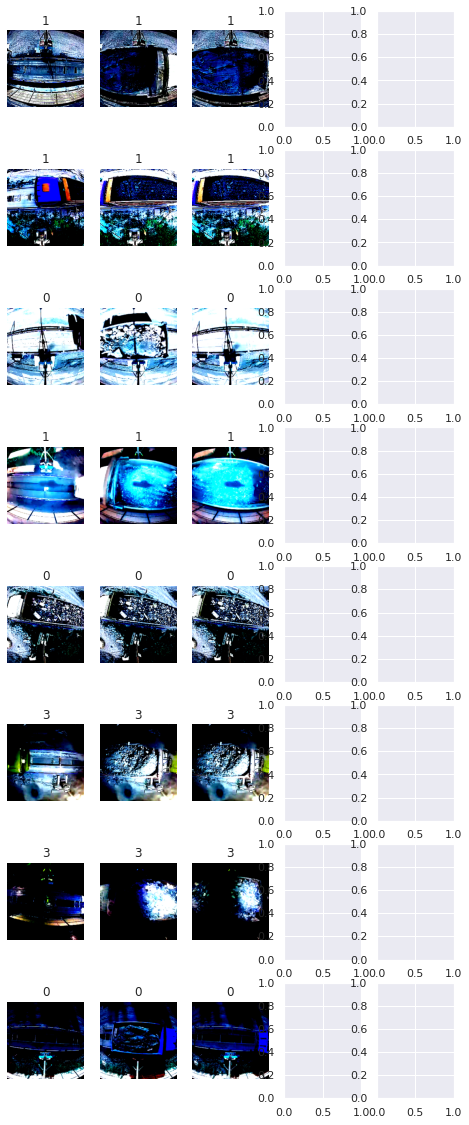

In [146]:
random_indices = random.sample(range(80), 8)
print(random_indices)
fig, ax = plt.subplots(8, 5, figsize=(8, 20))
for i, idx in enumerate(random_indices):
    img, cl = testdataset[idx]
    img1, img2, img3 = img[0], img[1], img[2]
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    img3 = img3.permute(1, 2, 0).numpy()
    ax[i, 0].imshow(img1)
    ax[i, 0].set_title(str(cl))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(img2)
    ax[i, 1].set_title(str(cl))
    ax[i, 1].axis('off')
    ax[i, 2].imshow(img3)
    ax[i, 2].set_title(str(cl))
    ax[i, 2].axis('off')

In [165]:
from torch.utils.data import DataLoader

train_loader = DataLoader(traindataset, batch_size=64, shuffle=True)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=False)


In [148]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [170]:
from torchvision import models
import torch.nn.functional as F
device = 'cpu'
class CustomRegnet(nn.Module):
    def __init__(self, num_freeze_layers=0):
        super(CustomRegnet, self).__init__()
        self.res = models.regnet.regnet_y_400mf(pretrained=True)
        self.res.fc = nn.Sequential(nn.Linear(440, 4))
    
    def forward(self, x):
        return self.res(x)

class Wastes_Classifier(nn.Module):
    def __init__(self):

        super(Wastes_Classifier, self).__init__()

        self.reses = CustomRegnet()
        self.classifier = nn.Linear(12, 4)
       
    def forward(self, img):
        out = []
        for i in range(3):
            out.append(self.reses(img[:,i,:,:,:]))
        out = torch.cat(out, dim=1)
        out = F.dropout(out, p=0.65, training=self.training)

        return self.classifier(out)
    def give_one_photo(self, file_name):
        trans  = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        name = file_name
        video_file = []


        start_time = 119  # начальное время (2 минуты)
        end_time = 135    # конечное время (3 минуты)

        # Открываем исходное видеофайл
        video = cv2.VideoCapture(name)

        if int(video.get(cv2.CAP_PROP_FRAME_COUNT)) != 240 * 12:
            print("Video has wrong size!!!")
            return torch.Tensor([-1])

        # Вычисляем FPS (кадры в секунду)
        fps = 12

        # Вычисляем количество кадров, которые нужно пропустить
        start_frame = int(start_time * fps)
        end_frame = int(end_time * fps)

        # Устанавливаем текущий кадр на начальный
        video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        # Обрабатываем и отображаем кадры в заданном временном промежутке
        for frame_number in range(start_frame, end_frame):
            ret, frame = video.read()
            if not ret:
                break
            video_file.append(frame / 255)

        # Закрываем видеопоток
        video.release()
        first = int(16 * 12) - 1
        second = first - 12 * 5
        third = second - 12 * 10

        video_itg = torch.from_numpy(np.stack([video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2)
        video_itg = trans(video_itg)
        vidos = video_itg.to(torch.float32)

        return vidos
    
    def infer(self, dir_file, is_folder=False, device='cpu'):
        
        
        if is_folder:
            data = []
            for name in dir_file:
                data.append(self.give_one_photo(name))
            data = torch.stack(data)
        else:
            data = self.give_one_photo(dir_file).unsqueeze(0)
        data = data.to(device)
        device = device
        
        if device == 'cpu':
            dataset = DataLoader(data, batch_size=4, num_workers=os.cpu_count())
        else:
            dataset = DataLoader(data, batch_size=16)
            
            
        answer_itg = []
        for batch in dataset:
            out = []
            for i in range(3):
                out.append(self.reses(batch[:,i,:,:,:]))
            out = torch.cat(out, dim=1)

            answer = self.classifier(out)
            answer_itg.append(torch.argmax(answer, dim=1))
        
        
        return torch.cat(answer_itg)
model = Wastes_Classifier()
model.to(device)

Wastes_Classifier(
  (reses): CustomRegnet(
    (res): RegNet(
      (stem): SimpleStemIN(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (trunk_output): Sequential(
        (block1): AnyStage(
          (block1-0): ResBottleneckBlock(
            (proj): Conv2dNormActivation(
              (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (f): BottleneckTransform(
              (a): Conv2dNormActivation(
                (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
              )
              (b): Conv2dNo

In [ ]:
model.to('cpu')
torch.cuda.empty_cache()

In [167]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [171]:
def train(model, loss_fn, optimizer, n_epoch=100):
    save_path = 'model_folder'
    train_loss_list = []
    test_loss_list = []

    for epoch in tqdm(range(n_epoch)):
        model.train(True)
        train_loss = 0
        train_acc = 0

        test_loss = 0
        test_acc = 0

        num_correct_test = 0
        num_correct_train = 0


        for i, batch in enumerate(train_loader):

            optimizer.zero_grad()

            X_batch, y_batch = batch[0].to(torch.float32).to(device), batch[1].to(device)

            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            y_pred = torch.argmax(logits, dim=1)

            num_correct_train += torch.sum(y_pred.cpu() == y_batch.cpu())

        train_acc = num_correct_train / len(traindataset)
        train_loss = train_loss / len(train_loader)


        # if i <= 50:
        #     scheduler.step()
        train_loss_list.append(train_loss)


        model.eval()
        with torch.no_grad():
            for batch in (test_loader):



                X_batch, y_batch = batch[0].to(torch.float32).to(device), batch[1].to(device)

                y_pred = model(X_batch.to(device))
                test_loss += loss_fn(y_pred, y_batch).item()

                y_pred = torch.argmax(y_pred, dim=1)

                num_correct_test += torch.sum(y_pred.cpu() == y_batch.cpu())


            test_loss_list.append(test_loss / len(test_loader))
            test_acc = num_correct_test / len(testdataset)



        if epoch % 1 == 0:

            print(f'Train loss: {train_loss}||Test loss: {test_loss_list[-1]}')
            print(f'Train acc: {train_acc}||Test acc: {test_acc}')
            if epoch != 0:
                fig, ax = plt.subplots(1, 2, figsize=(10, 3))
                ax[0].plot(train_loss_list)
                ax[0].set_title('Тренировачная кривая обучения')
                ax[1].plot(test_loss_list)
                ax[1].set_title('Тестовая кривая обучения')
                plt.show()
            if epoch % 100 == 0:
                model_save_path = os.path.join(save_path, f'model_epoch_{epoch}.pt')
                torch.save(model.state_dict(), model_save_path)
    return model


In [176]:
model.load_state_dict(torch.load('model_folder/resnet95.pt'))

<All keys matched successfully>

In [172]:
model = train(model, loss_fn, optimizer, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [177]:
model.eval()
from sklearn.metrics import confusion_matrix

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in testdataset:
        inputs = inputs.unsqueeze(0).to(device).to(torch.float32)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_labels.append(labels)
        all_predictions.append(predictions.tolist())

conf_matrix = confusion_matrix(all_labels, all_predictions)


In [42]:
model.cpu()
torch.cuda.empty_cache()

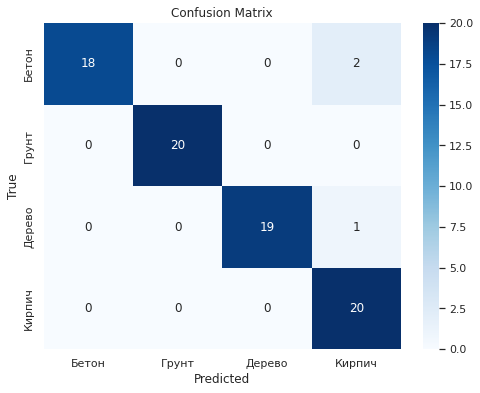

In [178]:
import seaborn as sns
sns.set()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Бетон', 'Грунт', 'Дерево', 'Кирпич'],
            yticklabels=['Бетон', 'Грунт', 'Дерево', 'Кирпич'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [119]:
%%time
model.eval()
with torch.inference_mode():
    answer = model.infer("H930HK790_04_17_2023 23_23_05.mp4", False, device=device)
print(answer)

tensor([1], device='cuda:0')
CPU times: user 1.86 s, sys: 43.2 ms, total: 1.9 s
Wall time: 1.04 s


In [26]:
video_file = []

start_time = 119  # начальное время (2 минуты)
end_time = 135    # конечное время (3 минуты)
name = "K535HA797_07_12_2023 11_55_14.mp4"
# Открываем исходное видеофайл
video = cv2.VideoCapture(name)

# Вычисляем FPS (кадры в секунду)
fps = 12

# Вычисляем количество кадров, которые нужно пропустить
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Устанавливаем текущий кадр на начальный
video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Обрабатываем и отображаем кадры в заданном временном промежутке
for frame_number in range(start_frame, end_frame):
    ret, frame = video.read()
    if not ret:
        break
    video_file.append(frame / 255)

# Закрываем видеопоток
video.release()
first = int(16 * 12) - 1
second = first - 12 * 5
third = second - 12 * 10

In [27]:
video_itg = torch.from_numpy(np.stack([video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2)
trans = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
video_itg = trans(video_itg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

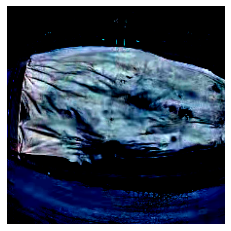

In [30]:
img1, img2, img3 = video_itg[0], video_itg[2], video_itg[1]
img1 = img1.permute(1, 2, 0).numpy()
img2 = img2.permute(1, 2, 0).numpy()
img3 = img3.permute(1, 2, 0).numpy()
plt.imshow(img3)
plt.axis('off')

In [28]:
with torch.inference_mode():
    logits = model(video_itg.unsqueeze(0).to(device).to(torch.float32))

In [29]:
nn.functional.softmax(logits)

tensor([[9.9918e-01, 3.3525e-06, 3.9818e-08, 8.1987e-04]], device='cuda:0')

In [89]:
model_save_path = os.path.join('model_folder', f'resnet95.pt')
torch.save(model.state_dict(), model_save_path)

In [175]:
!unzip -qq test_dataset_test.zip

In [180]:
import os

def list_files_in_directory(directory):
    path_list = []
    file_list = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            path_list.append(os.path.join(directory, filename))
            file_list.append(filename)
    return path_list, file_list


folder_path = 'videos'
path_list, file_list = list_files_in_directory(folder_path)




In [ ]:
class_dictionary = {0: '1',
                    1: '3',
                    2: '2',
                    3: '4'}

In [ ]:
ans_dict = {0: "Бетон", 1: "Грунт", 2: "Дерево", 3: "Кирпич", -1: "Неверный файл"}

class CustomRegnet(nn.Module):
    def __init__(self, num_freeze_layers=0):
        super(CustomRegnet, self).__init__()
        self.res = models.regnet.regnet_y_400mf(weights=None)
        self.res.fc = nn.Sequential(nn.Linear(440, 4))
    
    def forward(self, x):
        return self.res(x)

class Wastes_Classifier(nn.Module):
    def __init__(self):

        super(Wastes_Classifier, self).__init__()

        self.reses = CustomRegnet()
        self.classifier = nn.Linear(12, 4)
       
    def forward(self, img):
        out = []
        for i in range(3):
            out.append(self.reses(img[:,i,:,:,:]))
        out = torch.cat(out, dim=1)
        out = F.dropout(out, p=0.65, training=self.training)

        return self.classifier(out)
    def give_one_photo(self, file_name):
        trans  = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        name = file_name
        video_file = []


        start_time = 119  # начальное время (2 минуты)
        end_time = 135    # конечное время (3 минуты)

        # Открываем исходное видеофайл
        video = cv2.VideoCapture(name)

        # if int(video.get(cv2.CAP_PROP_FRAME_COUNT)) < 180 * 12:
        #     print("Video has wrong size!!!", name)
        #     return torch.Tensor([-1])

        # Вычисляем FPS (кадры в секунду)
        fps = int(video.get(cv2.CAP_PROP_FPS))


        # Вычисляем количество кадров, которые нужно пропустить
        start_frame = int(start_time * fps)
        end_frame = int(end_time * fps)

        # Устанавливаем текущий кадр на начальный
        video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        # Обрабатываем и отображаем кадры в заданном временном промежутке
        for frame_number in range(start_frame, end_frame):
            ret, frame = video.read()
            if not ret:
                break
            video_file.append(frame / 255)

        # Закрываем видеопоток
        video.release()
        first = 16 * fps - 1
        second = first - fps * 5
        third = second - fps * 10

        video_itg = torch.from_numpy(np.stack([video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2)
        video_itg = trans(video_itg)
        vidos = video_itg.to(torch.float32)

        return vidos
    
    def infer(self, dir_file, is_folder=False, device='cpu'):
        
        
        if is_folder:
            data = []
            for name in tqdm(dir_file):
                photo = self.give_one_photo(name)
                if photo.shape == (3, 3, 224, 224):
                    data.append(self.give_one_photo(name))
            data = torch.stack(data)
        else:
            data = self.give_one_photo(dir_file).unsqueeze(0)
        data = data.to(device)
        device = device
        
        if device == 'cpu':
            dataset = DataLoader(data, batch_size=4, num_workers=os.cpu_count())
        else:
            print('here')
            dataset = DataLoader(data, batch_size=16)
            
            
        answer_itg = []
        for batch in tqdm(dataset):
            out = []
            for i in range(3):
                out.append(self.reses(batch[:,i,:,:,:]))
            out = torch.cat(out, dim=1)

            answer = self.classifier(out)
            answer_itg.append(torch.argmax(answer, dim=1))
        
        
        return torch.cat(answer_itg)
model = Wastes_Classifier()
model.to('cuda')
model.load_state_dict(torch.load('model_folder/resnet95.pt'))

In [ ]:
model.eval()

with torch.inference_mode():
    ans = model.infer(path_list, True, 'cuda')

In [ ]:
ans

In [ ]:
import pandas as pd
